In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing:

In [2]:
inp_file = '../../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py36_WNTR/lib/python3.6/site-packages/wntr/epanet/io.py:2085: UserWarning:

Not all curves were used in "../../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [5]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_0.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Junctions:
Pressure and demand.

In [18]:
junction_pressure = results.node['pressure'][node_names[2]]
junction_pressure.shape

(721, 378)

In [19]:
junction_demand = results.node['demand'][node_names[2]]

## Tank levels:

In [13]:
tank_level = results.node['pressure'][node_names[0]]
tank_level.shape

(721, 7)

## Pumps:

In [14]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

In [15]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,60.926741,30.337207,57.729275,30.484445,19.474339
3600,179.894788,146.678292,266.693973,17.642207,0.000000
7200,179.146975,37.104481,167.199208,17.613832,0.000000


## Valves

In [16]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

## Neural Network Pre-Processing
### NN inputs:

In [30]:
input_1_dict = {
    'junction_demand': junction_demand
}

nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level,
    'head_pump_speed': head_pump_speed_corr,             
    'PRValve_dp': PRValve_dp,          
    'TCValve_throttle': TCValve_throttle
}

nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

nn_input_dict = {
    '1': nn_inputs_1,
    '2': nn_inputs_2
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

1                                                    \
     junction_demand                                                     
name            J511      J411      J414 J415 J416      J417 J418 J419   
0            0.00101  0.000415  0.000451  0.0  0.0  0.000602  0.0  0.0   
3600         0.00088  0.000473  0.000514  0.0  0.0  0.000687  0.0  0.0   

                          ...          2                                    \
                          ... tank_level head_pump_speed                     
name      J310      J311  ...         T4             PU2      PU5      PU6   
0     0.001027  0.000894  ...   3.683855         1.00000  1.00000  1.00000   
3600  0.000779  0.000678  ...   3.430354         1.50924  1.72955  1.80228   

                                                                          
                     PRValve_dp                         TCValve_throttle  
name       PU8 PU10          V1         V45         V47               V2  
0     1.000000  1.0  507.295166  583.340271  531.153015        16.349977  
3600  0.835681  0.0  507.295166  583.340271  531.153015        16.349977  

[2 rows x 394 columns]

### NN outputs:

In [31]:
dtank_level = tank_level.diff(axis=0)
dtank_level_next = dtank_level.shift(-1, axis=0)

output_1_dict ={
    'junction_pressure': junction_pressure,
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'dtank_level_next': dtank_level_next,
    'pump_energy': pump_energy,
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

nn_output_dict = {
    '1': nn_outputs_1,
    '2': nn_outputs_2
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

1                                                \
     junction_pressure                                                 
name              J511       J411       J414        J415        J416   
0            31.067541  66.957504  37.684246   84.249519   98.557381   
3600         32.984055  70.013931  37.980427  164.388840  149.868896   

                                                             ...  \
                                                             ...   
name       J417       J418       J419       J310       J311  ...   
0     33.396194  30.309166  26.899286  52.477169  48.400047  ...   
3600  32.762733  27.208258  24.439222  48.539520  44.449219  ...   

                    2                                                      \
     dtank_level_next                                         pump_energy   
name               T7        T6        T5        T2        T4         PU2   
0           -0.191328  0.236646  0.551724  0.038128 -0.253501   60.926741   
3600        -1.645444 -0.317813  0.512025 -0.141554  1.269643  179.894788   

                                                    
                                                    
name         PU5         PU6        PU8       PU10  
0      30.337207   57.729275  30.484445  19.474339  
3600  146.678292  266.693973  17.642207   0.000000  

[2 rows x 390 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [32]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=720, n_inputs = 394, n_outputs=390


In [52]:
input_scaling = nn_input.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input/input_scaling

output_scaling = nn_output.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [536]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
nonnegunit_cons =  nonnegUnitNorm(axis=1)

l1_penalty = tf.keras.regularizers.l1(l=0.001)
l2_penalty = tf.keras.regularizers.l2(l=0.1)

In [545]:
n_cluster = 30

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['1'].shape[1]), name='in_1')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_in_1', 
    use_bias=False, 
    kernel_regularizer=l1_penalty,
    kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2
tf_in_2 = tf.keras.Input(shape=(nn_input['2'].shape[1],), name='in_2')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2], name='input_concatenate')

# Intermediate (non-linear) layers:
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_1')(tf_in_cat)
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_2')(tf_interm)
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_3')(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['1'].shape[1], 
    name='out_1', 
    use_bias=False,
    kernel_constraint=nonneg_cons,
)(tf_interm_1)
tf_out_2 = tf.keras.layers.Dense(nn_output['2'].shape[1], name='out_2')(tf_interm_2)


In [538]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2], outputs=[tf_out_1,tf_out_2])

In [539]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [540]:
%%capture
history = model.fit([nn_input_scaled['1'], nn_input_scaled['2']], 
                    [nn_output_scaled['1'], nn_output_scaled['2']], 
                    batch_size=50, 
                    epochs=1000)

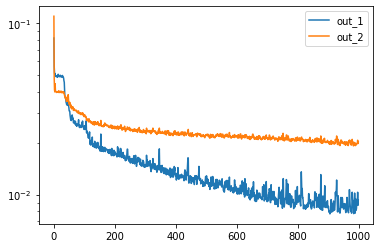

In [541]:
plt.semilogy(history.epoch,history.history['out_1_loss'], label='out_1')
plt.semilogy(history.epoch,history.history['out_2_loss'], label='out_2')
plt.legend()

In [542]:
A_cluster = model.get_layer('cluster_in_1').get_weights()[0]

In [543]:
np.sum(A_cluster,axis=1)

array([5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477,
       5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477,
       5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477,
       5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477, 5.477,

In [500]:
A_cluster[np.abs(A_cluster)<1e-3]=0

In [501]:
np.sum(A_cluster!=0)

378

In [507]:
A_decluster = model.get_layer('out_1').get_weights()[0]

In [508]:
np.sum(A_decluster!=0)

7494

In [509]:
np.sum(A_decluster==0)

66